# Basic MERCS

## Imports etc

In [1]:
import mercs
import numpy as np
from mercs.tests import load_iris, default_dataset
from mercs.core import Mercs

## Testdrive

Here a small MERCS testdrive for what I suppose you'll need. First, let us generate a basic dataset. Some utility-functions are integrated in MERCS so that goes like this

In [2]:
train, test = default_dataset(n_features=4 * 10 ** 0)
train[:20]

array([[-1.32215078, -0.79095656,  0.51626038, -0.48405183,  1.        ],
       [-1.81333888,  0.62979917,  0.97189032,  1.93749521,  1.        ],
       [-0.86602753, -0.7458731 ,  0.34843253, -1.04698596,  1.        ],
       [-0.4310274 , -0.19616028, -2.8226608 , -1.44558936,  0.        ],
       [-2.51221012, -3.31467898,  4.22965537,  0.14797735,  0.        ],
       [-0.03665064,  0.07566481,  2.15518439,  1.21783179,  0.        ],
       [-1.12285279, -1.20080724,  0.60774537, -0.17858784,  0.        ],
       [-1.12416734, -1.02493785, -1.05914756, -1.90971485,  0.        ],
       [-1.2152382 , -2.86791935,  1.10903289, -3.02430913,  1.        ],
       [-0.3775988 , -0.7107917 , -0.73213335, -2.3530741 ,  0.        ],
       [ 0.12210504,  0.44135258,  2.26863961, -0.08306471,  0.        ],
       [ 0.5373043 , -0.2780344 ,  2.43787375,  2.68441233,  0.        ],
       [ 1.47020219, -0.46290396, -2.32769304,  1.26565925,  1.        ],
       [ 1.14584153, -0.09836175, -2.0

Now let's train a MERCS model. To know what options you have, come talk to me or dig in the code. For induction, `nb_targets` and `nb_iterations` matter most. Number of targets speaks for itself, number of iterations manages the amount of trees _for each target_. With `n_jobs` you can do multi-core learning (with joblib, really basic, but works fine on single machine), that makes stuff faster. `fraction_missing` sets the amount of attributes that is missing for a tree. However, this parameter only has an effect if you use the `random` selection algorithm. The alternative is the `base` algorithm, which selects targets, and uses all the rest as input.

In [3]:
clf = Mercs(
    max_depth=4,
    selection_algorithm="random",
    fraction_missing=0.6,
    nb_targets=2,
    nb_iterations=2,
    n_jobs=8,
    verbose=1,
    inference_algorithm="dask",
    max_steps=8,
    prediction_algorithm="it",
)

You have to specify the nominal attributes yourself. This determines whether a regressor or a classifier is learned for that target. MERCS takes care of grouping targets such that no mixed sets are created.

In [4]:
nominal_ids = {train.shape[1]-1}
nominal_ids

{4}

In [5]:
clf.fit(train, nominal_attributes=nominal_ids)

/cw/dtaijupiter/NoCsBack/dtai/elia/mercs/src/mercs/algo/induction.py:185: UserWarning: Training is being parallellized using Joblib. Number of jobs = 8
  warnings.warn(msg)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    2.2s finished
/cw/dtaijupiter/NoCsBack/dtai/elia/miniconda/envs/rwrf/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So, now we have learned trees with two targets, but only a single target was nominal. If MERCS worked well, it should have learned single-target classifiers (for attribute 4) and multi-target regressors for all other target sets.

In [6]:
clf.m_list

So, that looks good already. Let's examine up close.

In [7]:
clf.m_codes

array([[-1,  0,  0, -1,  1],
       [-1, -1,  0,  0,  1],
       [ 1,  0,  1,  0, -1],
       [-1,  1, -1,  1,  0],
       [ 1,  0,  1,  0,  0],
       [-1,  1,  0,  1, -1]])

That's the matrix that summarizes everything. This can be dense to parse, and there's alternatives to gain insights, for instance;

In [8]:
for m_idx, m in enumerate(clf.m_list):
    msg = """
    Tree with id:          {}
    has source attributes: {}
    has target attributes: {},
    and predicts {} attributes
    """.format(m_idx, m.desc_ids, m.targ_ids, m.out_kind)
    print(msg)


    Tree with id:          0
    has source attributes: [1, 2]
    has target attributes: [4],
    and predicts nominal attributes
    

    Tree with id:          1
    has source attributes: [2, 3]
    has target attributes: [4],
    and predicts nominal attributes
    

    Tree with id:          2
    has source attributes: [1, 3]
    has target attributes: [0, 2],
    and predicts numeric attributes
    

    Tree with id:          3
    has source attributes: [4]
    has target attributes: [1, 3],
    and predicts numeric attributes
    

    Tree with id:          4
    has source attributes: [1, 3, 4]
    has target attributes: [0, 2],
    and predicts numeric attributes
    

    Tree with id:          5
    has source attributes: [2]
    has target attributes: [1, 3],
    and predicts numeric attributes
    


And that concludes my quick tour of MERCS learns this stuff. Let me know if it does not behave as it should.

# Prediction

First, we generate a query.

In [9]:
# Single target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
q_code

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 0.])

In [10]:
# Multi-target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-2:] = 1
q_code

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

array([[ 0.06746825,  0.        ],
       [-0.57445471,  1.        ],
       [ 1.58481446,  0.        ],
       [-0.57445471,  1.        ],
       [-0.20623665,  0.        ],
       [-0.20623665,  0.        ],
       [-0.57445471,  1.        ],
       [ 1.58481446,  0.        ],
       [ 0.06746825,  1.        ],
       [-0.20623665,  0.        ]])

In [11]:
# Missing attributes
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
q_code[:1] = -1
print(q_code)

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

[-1  0  0  0  1]


array([0., 0., 0., 0., 1., 1., 1., 1., 0., 0.])

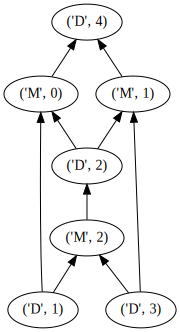

In [12]:
clf.show_q_diagram()